#### We would run a set of models to establish a base line of accuracy

In [ ]:
import pandas as panda
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler,label_binarize

from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RepeatedStratifiedKFold,learning_curve

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, \
        classification_report,confusion_matrix,average_precision_score
from sklearn.linear_model import Perceptron, LogisticRegression,RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plot
from itertools import cycle
import numpy as np 
from scipy import interp
import seaborn as sns
import itertools, time, datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from numpy import bincount, linspace, mean, std, arange, squeeze

import warnings

warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
np.random.seed(123)

In [3]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plot.imshow(cm, interpolation='nearest', cmap=cmap)
    plot.title(title)
    plot.colorbar()
    tick_marks = arange(len(classes))
    plot.xticks(tick_marks, classes, rotation=45)
    plot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plot.ylabel('True label')
    plot.xlabel('Predicted label')
#     plot.tight_layout()
    plot.show()

In [6]:
## over sampling majorities first 

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
# _x_train, _y_train = smt.fit_sample(_x_train, _y_train)

# smote = SMOTE(ratio='minority')
# x_train, y_train = smote.fit_sample(_x_train,_y_train)

# tl = TomekLinks(return_indices=True, ratio='majority')
# _x_train, _y_train, id_tl = tl.fit_sample(_x_train, _y_train)



In [7]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))





def calculate_roc_and_prec_metrics(y, y_probabilities, number_of_classes):
    
    false_positive_rate_across_class    = dict()
    true_positive_rate_across_class     = dict()
    recall_across_class                 = dict()
    precision_across_class              = dict()
    roc_auc_across_class                = dict()
    average_precision_across_class      = dict()


    for i in range(number_of_classes):

        false_positive_rate_across_class[i], \
                true_positive_rate_across_class[i], _ = roc_curve(y[:, i], y_probabilities[:, i])

        precision_across_class[i], recall_across_class[i], _ = precision_recall_curve(y[:, i],
                                                        y_probabilities[:, i])

        average_precision_across_class[i] = average_precision_score(y[:, i], y_probabilities[:, i])

        roc_auc_across_class[i] = auc(false_positive_rate_across_class[i], true_positive_rate_across_class[i])

        # Compute micro-average ROC curve and ROC area

        false_positive_rate_across_class["micro"], \
                true_positive_rate_across_class["micro"], _ = roc_curve(y.ravel(), y_probabilities.ravel())

        roc_auc_across_class["micro"] = auc(false_positive_rate_across_class["micro"], \
                            true_positive_rate_across_class["micro"])


        precision_across_class["micro"], recall_across_class["micro"], _ = \
                    precision_recall_curve(y.ravel(), y_probabilities.ravel())

        average_precision_across_class["micro"] = average_precision_score(y, y_probabilities,
                                                            average="micro")

    response  = dict() 
    response['false_positive_rate_across_class']    = false_positive_rate_across_class
    response['true_positive_rate_across_class']     = true_positive_rate_across_class
    response['recall_across_class']                 = recall_across_class
    response['precision_across_class']              = precision_across_class
    response['roc_auc_across_class']                = roc_auc_across_class
    response['average_precision_across_class']      = average_precision_across_class

    return response


def plot_roc_auc_curve(false_positive_rate_across_class, \
            true_positive_rate_across_class, roc_auc_across_class, n_classes):
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([false_positive_rate_across_class[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += interp(all_fpr, false_positive_rate_across_class[i], true_positive_rate_across_class[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    false_positive_rate_across_class["macro"] = all_fpr
    true_positive_rate_across_class["macro"] = mean_tpr
    roc_auc_across_class["macro"] = auc(false_positive_rate_across_class["macro"], true_positive_rate_across_class["macro"])

    # Plot all ROC curves
    plot.figure(figsize = (15,5))
    plot.plot(false_positive_rate_across_class["micro"], true_positive_rate_across_class["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc_across_class["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plot.plot(false_positive_rate_across_class["macro"], true_positive_rate_across_class["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc_across_class["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plot.plot(false_positive_rate_across_class[i], true_positive_rate_across_class[i], color=color, lw=4,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc_across_class[i]))

    plot.plot([0, 1], [0, 1], 'k--', lw=4)
    plot.xlim([0.0, 1.0])
    plot.ylim([0.0, 1.05])
    plot.xlabel('False Positive Rate')
    plot.ylabel('True Positive Rate')
    plot.title('Some extension of Receiver operating characteristic to multi-class')
    plot.legend(loc="lower right")
    plot.show()




def plot_precision_recall_curve(recall_across_class, \
            precision_across_class, average_precision_across_class, n_classes):

    line_width = 4
    from itertools import cycle
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    plot.figure(figsize=(15, 8))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plot.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plot.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plot.plot(recall_across_class["micro"], precision_across_class["micro"], color='gold', lw=line_width)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                ''.format(average_precision_across_class["micro"]))

    for i, color in zip(range(n_classes), colors):
        l, = plot.plot(recall_across_class[i], precision_across_class[i], color=color, lw=line_width)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                    ''.format(i, average_precision_across_class[i]))

    fig = plot.gcf()
    fig.subplots_adjust(bottom=0.25)
    plot.xlim([0.0, 1.0])
    plot.ylim([0.0, 1.05])
    plot.xlabel('Recall')
    plot.ylabel('Precision')
    plot.title('Extension of Precision-Recall curve to multi-class')
#     plot.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))
    plot.legend(lines, labels, loc='best', prop=dict(size=14))
    plot.show()

    

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  k_fold = 10, training_sample_sizes = linspace(0.1,1.0,10), jobsInParallel = 1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                X = _x_train, \
                                                                y = _y_train, \
                                                                train_sizes = training_sample_sizes, \
                                                                cv = k_fold, \
                                                                n_jobs = jobsInParallel) 


    training_mean = mean(training_score, axis = 1)
    training_std_deviation = std(training_score, axis = 1)
    testing_std_deviation = std(testing_score, axis = 1)
    testing_mean = mean(testing_score, axis = 1 )

    ## we have got the estimator in this case the perceptron running in 10 fold validation with 
    ## equal division of sizes betwwen .1 and 1. After execution, we get the number of training sizes used, 
    ## the training scores for those sizes and the test scores for those sizes. we will plot a scatter plot 
    ## to see the accuracy results and check for bias vs variance

    # training_size : essentially 10 sets of say a1, a2, a3,,...a10 sizes (this comes from train_size parameter, here we have given linespace for equal distribution betwwen 0.1 and 1 for 10 such values)
    # training_score : training score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    # testing_score : testing score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    ## the mean and std deviation for each are calculated simply to show ranges in the graph

    plot.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plot.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plot.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plot.fill_between(training_size, testing_mean+ training_std_deviation, testing_mean-training_std_deviation, color='green', alpha =0.14 )

    plot.title("Scoring of our training and testing data vs sample sizes")
    plot.xlabel("Number of Samples")
    plot.ylabel("Accuracy")
    plot.legend(loc= 'best')
    plot.show()
    
    
def runGridSearchAndPredict(pipeline, x_train, y_train, x_test, y_test, param_grid, n_jobs = 1, cv = 10, score = 'accuracy'):
    
    response = {}
    training_timer       = CodeTimer('training')
    testing_timer        = CodeTimer('testing')
    learning_curve_timer = CodeTimer('learning_curve')
    predict_proba_timer  = CodeTimer('predict_proba')
    
    with training_timer:
        
        gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = n_jobs, scoring = score)

        search = gridsearch.fit(x_train,y_train)

        print("Grid Search Best parameters ", search.best_params_)
        print("Grid Search Best score ", search.best_score_)

    with testing_timer:
        y_prediction = gridsearch.predict(x_test)
            
    print("F1 score %s" %f1_score(y_test,y_prediction, average ='weighted'))
    print("Classification report  \n %s" %(classification_report(y_test, y_prediction)))
    
    with learning_curve_timer:
        plotLearningCurve(_x_train, _y_train, search.best_estimator_)
#         _matrix = confusion_matrix(y_true = _y_test ,y_pred = y_prediction, labels = list(range(_y_test.shape[1])))
        _matrix = confusion_matrix(y_true = _y_test ,y_pred = y_prediction, labels = list(set(_y_test)))
        classes = list(set(_y_test))
        plot_confusion_matrix(_matrix, classes)
        
    with predict_proba_timer:

        if hasattr(gridsearch.best_estimator_, 'predict_proba'):
            
            print('inside decision function')
            y_probability = gridsearch.predict_proba(_x_test)
            number_of_classes = len(np.unique(y_train))
            y_test_bin = label_binarize(y_test, classes = np.unique(y_train))
            response = calculate_roc_and_prec_metrics(y_test_bin, y_probability, number_of_classes = number_of_classes)

            roc_params = {

                'false_positive_rate_across_class': response.get('false_positive_rate_across_class'),
                'true_positive_rate_across_class': response.get('true_positive_rate_across_class'),
                'roc_auc_across_class': response.get('roc_auc_across_class'),
                'n_classes': number_of_classes
            }

            precision_recall_params  = {

                'precision_across_class': response.get('precision_across_class'),
                'average_precision_across_class': response.get('average_precision_across_class'),
                'recall_across_class': response.get('recall_across_class'),
                'n_classes': number_of_classes
            }

            plot_roc_auc_curve(**roc_params)
            plot_precision_recall_curve(**precision_recall_params)
            response['roc_auc_micro'] = response.get('roc_auc_across_class',{}).get("micro")
            response['roc_auc_macro'] = response.get('roc_auc_across_class',{}).get("macro")
            
            
        else: ## eg SVM, Perceptron doesnt have predict_proba method
            
            response['roc_auc_micro'] = 0
            response['roc_auc_macro'] = 0
    
    response['learning_curve_time'] = learning_curve_timer.took
    response['testing_time'] = testing_timer.took
    response['_y_prediction'] = y_prediction
#     response['accuracy_score'] = accuracy_score(y_test,y_prediction)
    response['training_time'] = training_timer.took
    response['f1_score']  = f1_score(y_test, y_prediction, average ='weighted')
    response['f1_score_micro']  = f1_score(y_test, y_prediction, average ='micro')
    response['f1_score_macro']  = f1_score(y_test, y_prediction, average ='macro')
    response['best_estimator'] = search.best_estimator_
    response['confusion_matrix'] = _matrix
    
    return response


In [8]:
# y = label_binarize(y,classes = np.unique(y))



# _y_train.shape, _y_test.shape

## over sampling majorities first 

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
# _x_train, _y_train = smt.fit_sample(_x_train, _y_train)

In [9]:

## we will add more classifiers in round2
classifiers = [
    Perceptron(random_state = 1),
    LogisticRegression(random_state = 1),
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state = 1),
    KNeighborsClassifier(metric = 'minkowski'),
    RidgeClassifier(random_state = 123), 
]


classifier_names = [
            'perceptron',
            'logisticregression',
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
            'ridge'
]

classifier_param_grid = [
            
            {'perceptron__max_iter': [5,10,30], 'perceptron__eta0': [.1]},
            {'logisticregression__C':[100,300, 500]},
            {'decisiontreeclassifier__max_depth':[6,8,10],'decisiontreeclassifier__criterion':['gini','entropy']},
            {'randomforestclassifier__n_estimators':[6,8,12],'randomforestclassifier__criterion': ['gini',]} ,
            {'kneighborsclassifier__n_neighbors':[4,6,10]},
            {'ridge__alpha':[1,1.2,0.9],'ridge__max_iter':[100,300,500]}
    
]


In [10]:

def execute( _x_train,
             _y_train,
             _x_test,
             _y_test, 
            classifiers, 
            classifier_names, 
            classifier_param_grid,
            cv  = 10 , 
            score = 'accuracy',
            scaler = StandardScaler()
           ):
    
    '''
    This method will run your data sets against the model specified 
    Models will be fed through a pipeline where the first step would be to
    execute a scaling operation.
    
    Method will also call additional lower level methods in order to plot
    precision curve, roc curve, learning curve and will also prepare a confusion matrix
    
    :returns: dict containing execution metrics such as time taken, accuracy scores
    :returntype: dict
    
    '''

    timer = CodeTimer(name='overalltime')
    model_metrics = {}

    with timer:
        for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

            pipeline = Pipeline([
                    ('scaler', scaler),
                    (model_name, model)
            ])

            result = runGridSearchAndPredict(pipeline, 
                                             _x_train,
                                             _y_train,
                                             _x_test,
                                             _y_test, 
                                             model_param_grid ,
                                             cv = cv,
                                             score = 'f1_weighted')

            _y_prediction = result['_y_prediction']

#             cf = panda.crosstab(
#                 panda.Series(_y_test, name='Actual'),
#                 panda.Series(_y_prediction, name = 'Prediction'),
#                 margins = True
#             )

#             print(cf)

            model_metrics[model_name] = {}
            model_metrics[model_name]['confusion_matrix'] = result.get('confusion_matrix')
            model_metrics[model_name]['training_time'] = result.get('training_time')
            model_metrics[model_name]['testing_time'] = result.get('testing_time')
            model_metrics[model_name]['learning_curve_time'] = result.get('learning_curve_time')
            model_metrics[model_name]['f1_score'] = result.get('f1_score')
            model_metrics[model_name]['f1_score_macro'] = result.get('f1_score_macro')
            model_metrics[model_name]['f1_score_micro'] = result.get('f1_score_micro')
            model_metrics[model_name]['roc_auc_macro'] = result.get('roc_auc_macro')
            model_metrics[model_name]['roc_auc_micro'] = result.get('roc_auc_micro')

            model_metrics[model_name]['best_estimator'] = result.get('best_estimator')
            model_metrics[model_name]['cf'] = cf


    print(timer.took)
    
    return model_metrics


In [11]:
train_data = panda.read_csv('data/train_2.csv')
test_data = panda.read_csv('data/test_2.csv')

In [12]:

columns_not_required = ['id','idhogar','target']
x = train_data[[i for i in train_data.columns.tolist() if i not in columns_not_required]]
y = train_data['target']


In [13]:
_x_train,_x_test,_y_train,_y_test = train_test_split(x,y, test_size = 0.3, stratify= y, random_state =12)


In [14]:
_y_train[_y_train==4].shape[0]

1368

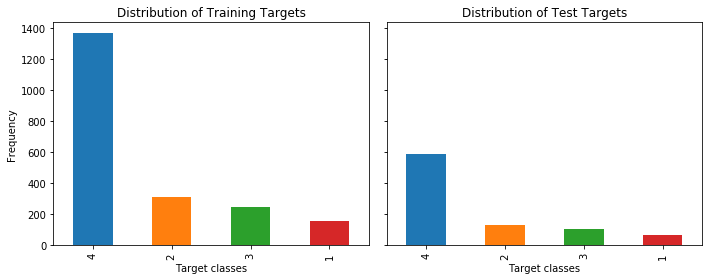

In [15]:


f, (ax1, ax2) = plot.subplots(1, 2, sharey=True, figsize=(10,4))
_y_train.value_counts().plot(kind='bar', label='Distribution of Training targets',ax=ax1)

ax1.set_xlabel('Target classes')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Training Targets')

_y_test.value_counts().plot(kind='bar', label='Distribution of Training targets', ax=ax2)

ax2.set_xlabel('Target classes')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Test Targets')
plot.tight_layout()
plot.show()

In [16]:
cv = StratifiedKFold(n_splits = 5, shuffle= True, random_state =123)
score= 'f1_weighted'
scaler = StandardScaler()

Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 5}
Grid Search Best score  0.5949427369583945
Code block 'training' took(HH:MM:SS): 0:00:02.241803
Code block 'testing' took(HH:MM:SS): 0:00:00.006109
F1 score 0.5930263513653721
Classification report  
               precision    recall  f1-score   support

           1       0.15      0.07      0.10        67
           2       0.26      0.28      0.27       133
           3       0.21      0.18      0.19       106
           4       0.77      0.82      0.80       586

   micro avg       0.61      0.61      0.61       892
   macro avg       0.35      0.34      0.34       892
weighted avg       0.58      0.61      0.59       892



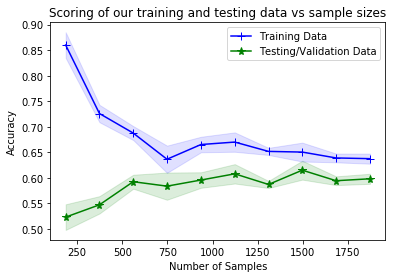

Confusion matrix, without normalization
[[  5  31   5  26]
 [ 13  37  24  59]
 [  5  23  19  59]
 [ 10  53  41 482]]


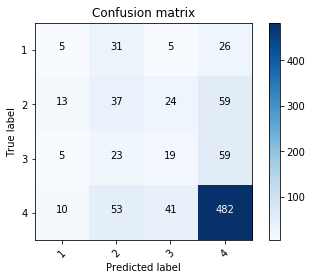

Code block 'learning_curve' took(HH:MM:SS): 0:00:06.695407
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000028
Prediction  1   2   3    4  All
Actual                         
1           0   1   2    4    7
2           0   5   3   20   28
3           1   5   0   17   23
4           6  34  30  143  213
All         7  45  35  184  271
Grid Search Best parameters  {'logisticregression__C': 300}
Grid Search Best score  0.6294752721287278
Code block 'training' took(HH:MM:SS): 0:01:01.344471
Code block 'testing' took(HH:MM:SS): 0:00:00.006643
F1 score 0.617661729428953
Classification report  
               precision    recall  f1-score   support

           1       0.28      0.16      0.21        67
           2       0.36      0.25      0.29       133
           3       0.21      0.11      0.15       106
           4       0.75      0.91      0.82       586

   micro avg       0.66      0.66      0.66       892
   macro avg       0.40      0.36      0.37       892
weighted avg       

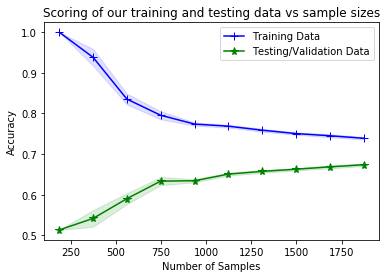

Confusion matrix, without normalization
[[ 11  15  10  31]
 [ 12  33  13  75]
 [  7  20  12  67]
 [  9  24  22 531]]


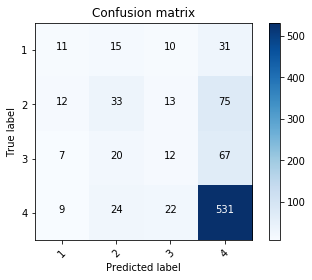

Code block 'learning_curve' took(HH:MM:SS): 0:03:48.318971
inside decision function


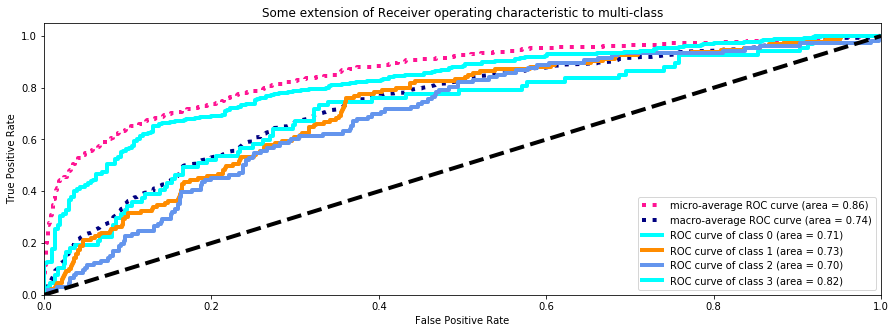

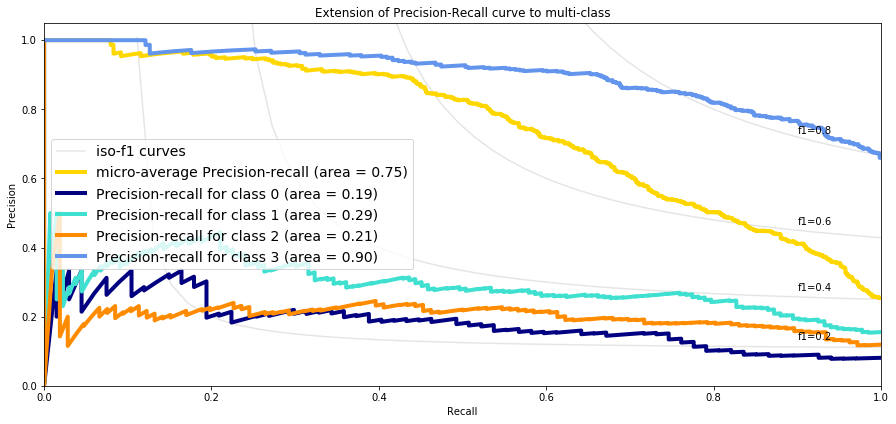

Code block 'predict_proba' took(HH:MM:SS): 0:00:01.019745
Prediction   1   2   3    4  All
Actual                          
1            0   1   0    6    7
2            1   3   2   22   28
3            1   1   2   19   23
4           15  18  18  162  213
All         17  23  22  209  271
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 6}
Grid Search Best score  0.5942152315872529
Code block 'training' took(HH:MM:SS): 0:00:04.063399
Code block 'testing' took(HH:MM:SS): 0:00:00.008101
F1 score 0.5975907920946922
Classification report  
               precision    recall  f1-score   support

           1       0.31      0.06      0.10        67
           2       0.35      0.42      0.38       133
           3       0.10      0.03      0.04       106
           4       0.74      0.87      0.80       586

   micro avg       0.64      0.64      0.64       892
   macro avg       0.37      0.35      0.33       892
weighted avg   

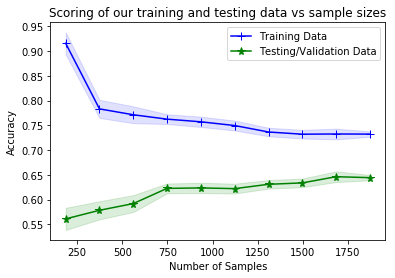

Confusion matrix, without normalization
[[  4  16   4  43]
 [  4  56   8  65]
 [  2  33   3  68]
 [  3  56  15 512]]


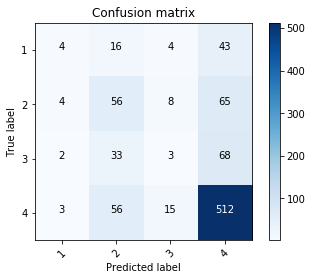

Code block 'learning_curve' took(HH:MM:SS): 0:00:06.974156
inside decision function


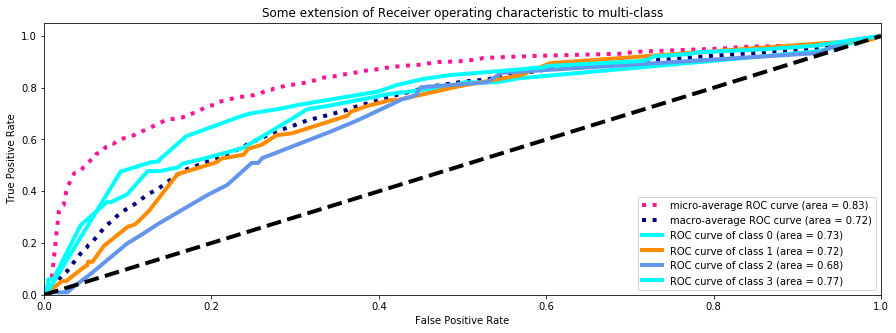

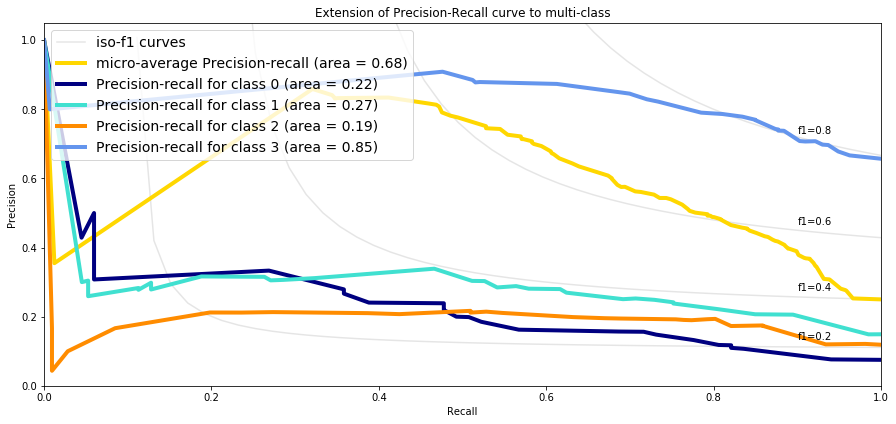

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.952225
Prediction  1   2   3    4  All
Actual                         
1           0   2   0    5    7
2           1   3   2   22   28
3           0   5   1   17   23
4           2  39  11  161  213
All         3  49  14  205  271
Grid Search Best parameters  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 12}
Grid Search Best score  0.6071226111359127
Code block 'training' took(HH:MM:SS): 0:00:02.150642
Code block 'testing' took(HH:MM:SS): 0:00:00.013632
F1 score 0.5953144926527538
Classification report  
               precision    recall  f1-score   support

           1       0.22      0.09      0.13        67
           2       0.31      0.29      0.30       133
           3       0.21      0.12      0.15       106
           4       0.74      0.86      0.80       586

   micro avg       0.63      0.63      0.63       892
   macro avg       0.37      0.34      0.34       892
weighted avg      

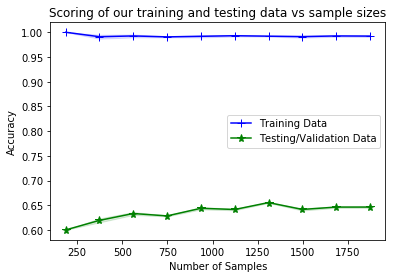

Confusion matrix, without normalization
[[  6  23   9  29]
 [  8  38  10  77]
 [  4  19  13  70]
 [  9  43  30 504]]


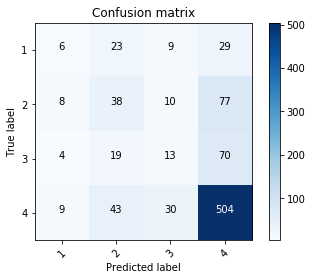

Code block 'learning_curve' took(HH:MM:SS): 0:00:10.986683
inside decision function


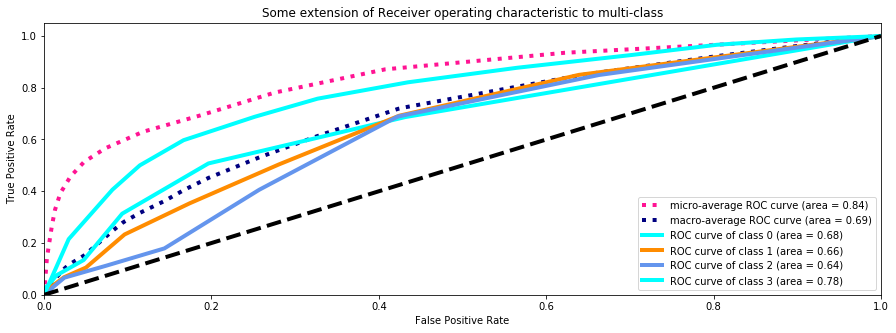

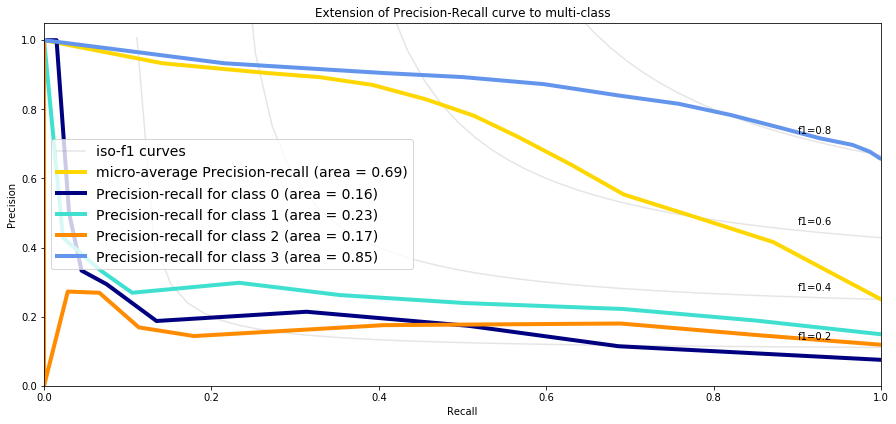

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.984939
Prediction  1   2   3    4  All
Actual                         
1           0   1   0    6    7
2           1   4   1   22   28
3           1   2   2   18   23
4           7  31  20  155  213
All         9  38  23  201  271
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 6}
Grid Search Best score  0.586955459059852
Code block 'training' took(HH:MM:SS): 0:00:33.470663
Code block 'testing' took(HH:MM:SS): 0:00:01.373976
F1 score 0.5941448023868162
Classification report  
               precision    recall  f1-score   support

           1       0.21      0.13      0.17        67
           2       0.29      0.19      0.23       133
           3       0.21      0.09      0.13       106
           4       0.74      0.90      0.81       586

   micro avg       0.64      0.64      0.64       892
   macro avg       0.36      0.33      0.33       892
weighted avg       0.57      0.64      0.59       892



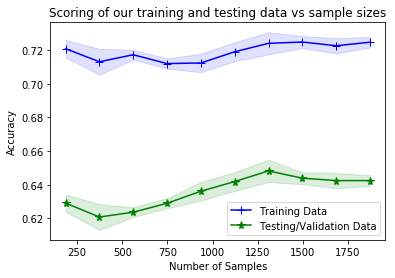

Confusion matrix, without normalization
[[  9  14   4  40]
 [ 16  25  16  76]
 [  5  17  10  74]
 [ 12  29  17 528]]


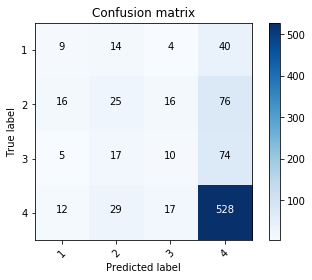

Code block 'learning_curve' took(HH:MM:SS): 0:01:44.722747
inside decision function


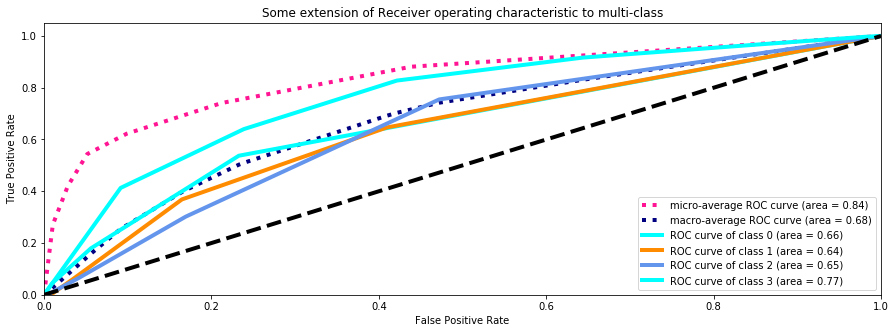

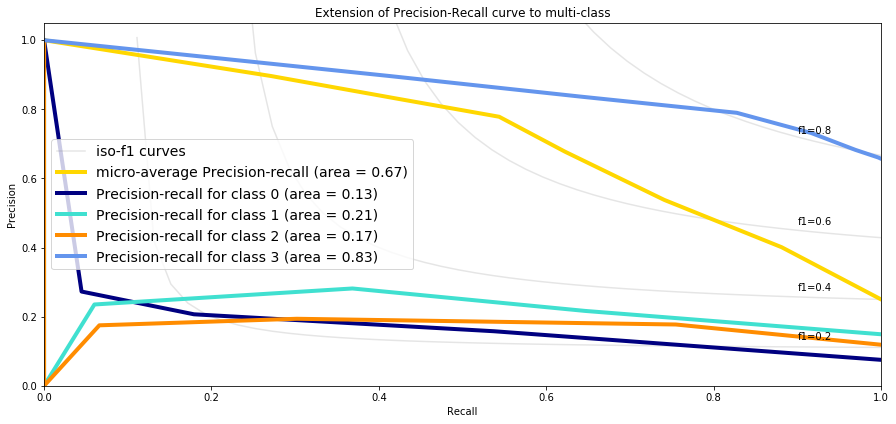

Code block 'predict_proba' took(HH:MM:SS): 0:00:02.259763
Prediction   1   2   3    4  All
Actual                          
1            1   2   1    3    7
2            1   4   0   23   28
3            1   5   2   15   23
4           11  17   9  176  213
All         14  28  12  217  271
Grid Search Best parameters  {'ridge__alpha': 1, 'ridge__max_iter': 100}
Grid Search Best score  0.6164810686753424
Code block 'training' took(HH:MM:SS): 0:00:03.016478
Code block 'testing' took(HH:MM:SS): 0:00:00.008055
F1 score 0.6069267887624569
Classification report  
               precision    recall  f1-score   support

           1       0.24      0.07      0.11        67
           2       0.37      0.28      0.32       133
           3       0.25      0.08      0.12       106
           4       0.73      0.92      0.82       586

   micro avg       0.66      0.66      0.66       892
   macro avg       0.40      0.34      0.34       892
weighted avg       0.58      0.66      0.61       892



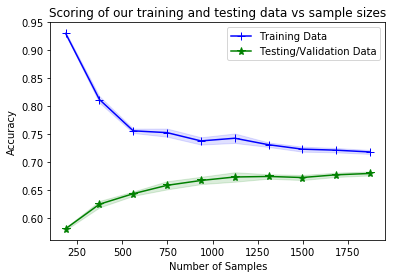

Confusion matrix, without normalization
[[  5  21   2  39]
 [  6  37   9  81]
 [  4  16   8  78]
 [  6  25  13 542]]


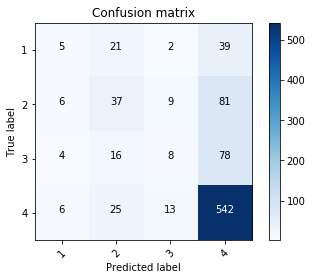

Code block 'learning_curve' took(HH:MM:SS): 0:00:04.855336
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000026
Prediction   1   2   3    4  All
Actual                          
1            0   1   0    6    7
2            1   4   1   22   28
3            1   2   1   19   23
4            8  20  11  174  213
All         10  27  13  221  271
Code block 'overalltime' took(HH:MM:SS): 0:07:56.075863
476075.8630184212


In [17]:
response = execute(_x_train,
        _y_train,
        _x_test,
        _y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=scaler)

In [28]:
results = panda.DataFrame(response).transpose()

# we are sorting our results using f1_score_micro, since it gives the best indicator for sorting multi class imbalanced set
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_macro',
         'roc_auc_micro',
         'testing_time',
         'training_time']]\
.sort_values(by=['f1_score_micro',],ascending=False)

,f1_score,f1_score_macro,f1_score_micro,learning_curve_time,roc_auc_macro,roc_auc_micro,testing_time,training_time
ridge,0.606927,0.34151,0.663677,4855.34,0,0,8.05546,3016.48
logisticregression,0.617662,0.367844,0.658072,228319,0.740316,0.859373,6.64291,61344.5
decisiontreeclassifier,0.597591,0.332209,0.644619,6974.16,0.724541,0.834315,8.10098,4063.4
kneighborsclassifier,0.594145,0.333758,0.641256,104723,0.677878,0.835289,1373.98,33470.7
randomforestclassifier,0.595314,0.343876,0.628924,10986.7,0.689347,0.837695,13.6317,2150.64
perceptron,0.593026,0.33935,0.608744,6695.41,0,0,6.1093,2241.8


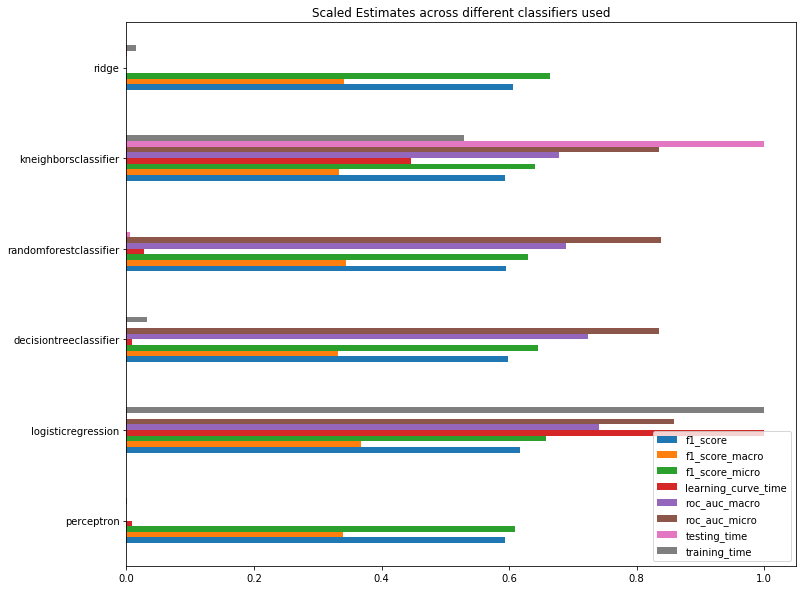

In [30]:
results['learning_curve_time'] = results['learning_curve_time'].astype('float64')
results['testing_time'] = results['testing_time'].astype('float64')
results['training_time'] = results['training_time'].astype('float64')
results['f1_score'] = results['f1_score'].astype('float64')
results['f1_score_micro'] = results['f1_score_micro'].astype('float64')
results['f1_score_macro'] = results['f1_score_macro'].astype('float64')
results['roc_auc_micro'] = results['roc_auc_micro'].astype('float64')
results['roc_auc_macro'] = results['roc_auc_macro'].astype('float64')

#scaling time parameters between 0 and 1
results['learning_curve_time'] = (results['learning_curve_time']- results['learning_curve_time'].min())/(results['learning_curve_time'].max()- results['learning_curve_time'].min())
results['testing_time'] = (results['testing_time']- results['testing_time'].min())/(results['testing_time'].max()- results['testing_time'].min())
results['training_time'] = (results['training_time']- results['training_time'].min())/(results['training_time'].max()- results['training_time'].min())

results.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

#### Conclusion on our baseline model: Logistic Regression works the best with f1_micro score of 0.66 and roc score of 0.86



<br><br><br>
##### We will attempt a different set of parameters now

In [16]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats= 5, random_state =123)
score= 'f1_macro'
scaler = StandardScaler()

In [32]:

## we will add more classifiers in round2
classifiers = [
    Perceptron(random_state = 1),
    LogisticRegression(random_state = 1),
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state = 1),
    KNeighborsClassifier(metric = 'minkowski'),
    RidgeClassifier(random_state = 123), 
    SVC(kernel='rbf',class_weight='balanced',probability=True)
]


classifier_names = [
            'perceptron',
            'logisticregression',
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
            'ridge',
            'svc'
]

classifier_param_grid = [
            
            {'perceptron__max_iter': [5,10,30], 'perceptron__eta0': [.1]},
            {'logisticregression__C':[100,300, 500]},
            {'decisiontreeclassifier__max_depth':[6,8,10],'decisiontreeclassifier__criterion':['gini','entropy']},
            {'randomforestclassifier__n_estimators':[6,8,12],'randomforestclassifier__criterion': ['gini',]} ,
            {'kneighborsclassifier__n_neighbors':[4,6,10]},
            {'ridge__alpha':[1,1.2,0.9],'ridge__max_iter':[100,300,500]},
            {'svc__C':[1,1.2,0.5], 'svc__max_iter':[100,200]}
    
]


Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 5}
Grid Search Best score  0.5949427369583945
Code block 'training' took(HH:MM:SS): 0:00:02.145336
Code block 'testing' took(HH:MM:SS): 0:00:00.018608
F1 score 0.5930263513653721
Classification report  
               precision    recall  f1-score   support

           1       0.15      0.07      0.10        67
           2       0.26      0.28      0.27       133
           3       0.21      0.18      0.19       106
           4       0.77      0.82      0.80       586

   micro avg       0.61      0.61      0.61       892
   macro avg       0.35      0.34      0.34       892
weighted avg       0.58      0.61      0.59       892



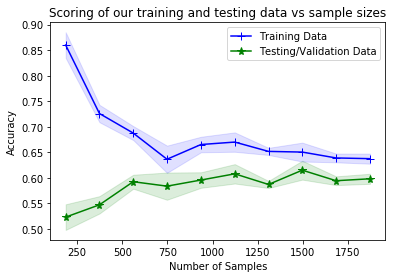

Confusion matrix, without normalization
[[  5  31   5  26]
 [ 13  37  24  59]
 [  5  23  19  59]
 [ 10  53  41 482]]


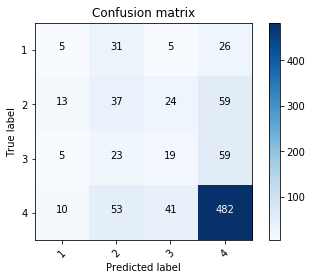

Code block 'learning_curve' took(HH:MM:SS): 0:00:06.067843
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000069
Prediction  1   2   3    4  All
Actual                         
1           0   1   2    4    7
2           0   5   3   20   28
3           1   5   0   17   23
4           6  34  30  143  213
All         7  45  35  184  271
Grid Search Best parameters  {'logisticregression__C': 300}
Grid Search Best score  0.6294752721287278
Code block 'training' took(HH:MM:SS): 0:00:59.838411
Code block 'testing' took(HH:MM:SS): 0:00:00.006951
F1 score 0.617661729428953
Classification report  
               precision    recall  f1-score   support

           1       0.28      0.16      0.21        67
           2       0.36      0.25      0.29       133
           3       0.21      0.11      0.15       106
           4       0.75      0.91      0.82       586

   micro avg       0.66      0.66      0.66       892
   macro avg       0.40      0.36      0.37       892
weighted avg       

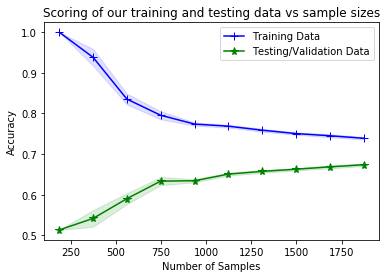

Confusion matrix, without normalization
[[ 11  15  10  31]
 [ 12  33  13  75]
 [  7  20  12  67]
 [  9  24  22 531]]


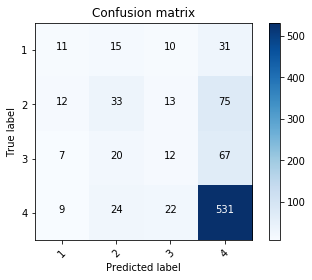

Code block 'learning_curve' took(HH:MM:SS): 0:02:58.315192
inside decision function


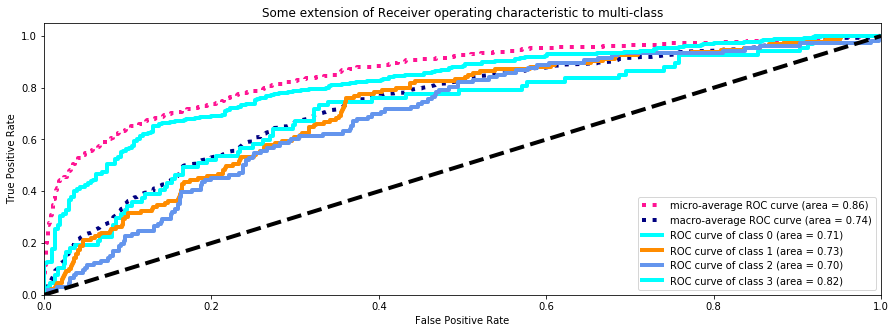

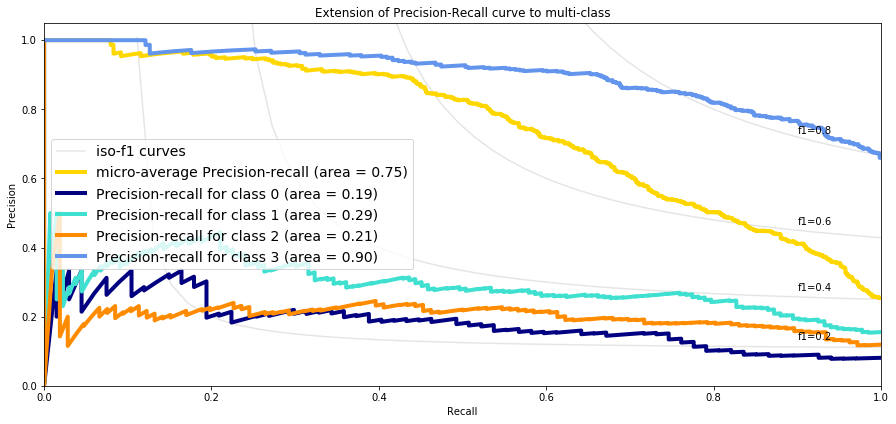

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.723783
Prediction   1   2   3    4  All
Actual                          
1            0   1   0    6    7
2            1   3   2   22   28
3            1   1   2   19   23
4           15  18  18  162  213
All         17  23  22  209  271
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 6}
Grid Search Best score  0.5939258226462862
Code block 'training' took(HH:MM:SS): 0:00:02.779748
Code block 'testing' took(HH:MM:SS): 0:00:00.006216
F1 score 0.5948679964243814
Classification report  
               precision    recall  f1-score   support

           1       0.31      0.06      0.10        67
           2       0.34      0.42      0.38       133
           3       0.07      0.02      0.03       106
           4       0.74      0.87      0.80       586

   micro avg       0.64      0.64      0.64       892
   macro avg       0.37      0.34      0.33       892
weighted avg   

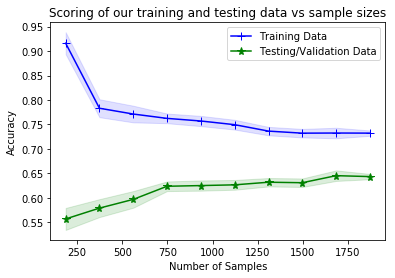

Confusion matrix, without normalization
[[  4  16   4  43]
 [  4  56   8  65]
 [  2  34   2  68]
 [  3  57  15 511]]


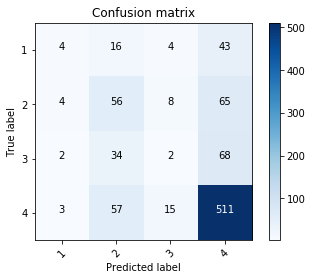

Code block 'learning_curve' took(HH:MM:SS): 0:00:04.989862
inside decision function


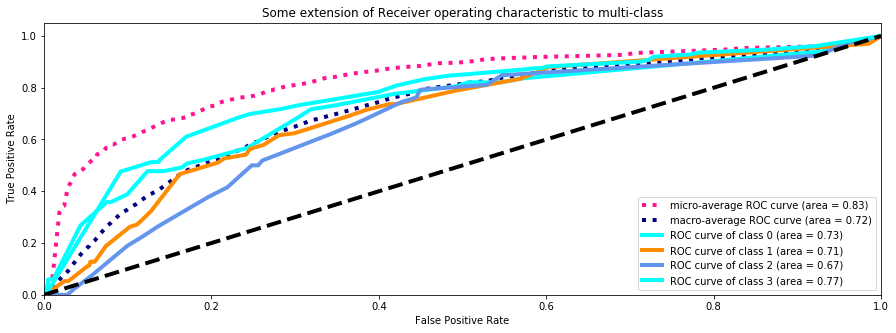

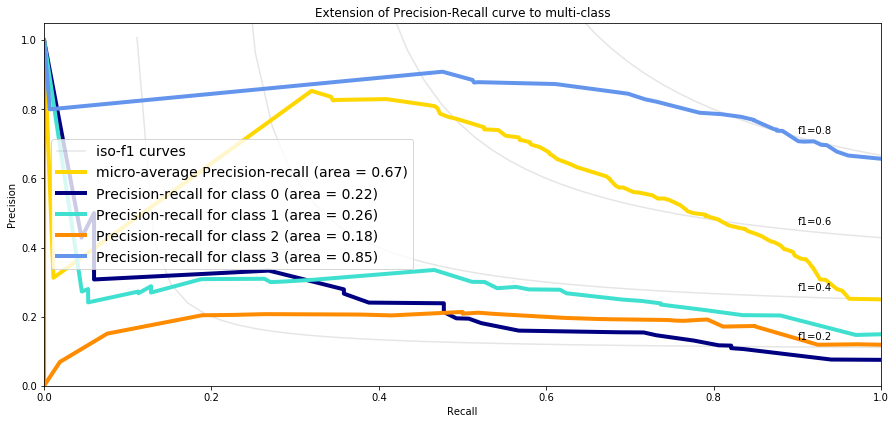

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.674497
Prediction  1   2   3    4  All
Actual                         
1           0   2   0    5    7
2           1   3   2   22   28
3           0   5   1   17   23
4           2  39  11  161  213
All         3  49  14  205  271
Grid Search Best parameters  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 12}
Grid Search Best score  0.6071226111359127
Code block 'training' took(HH:MM:SS): 0:00:01.573888
Code block 'testing' took(HH:MM:SS): 0:00:00.008896
F1 score 0.5953144926527538
Classification report  
               precision    recall  f1-score   support

           1       0.22      0.09      0.13        67
           2       0.31      0.29      0.30       133
           3       0.21      0.12      0.15       106
           4       0.74      0.86      0.80       586

   micro avg       0.63      0.63      0.63       892
   macro avg       0.37      0.34      0.34       892
weighted avg      

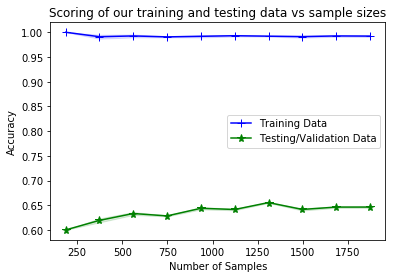

Confusion matrix, without normalization
[[  6  23   9  29]
 [  8  38  10  77]
 [  4  19  13  70]
 [  9  43  30 504]]


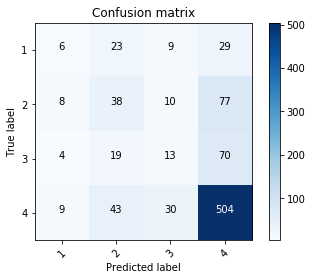

Code block 'learning_curve' took(HH:MM:SS): 0:00:07.993487
inside decision function


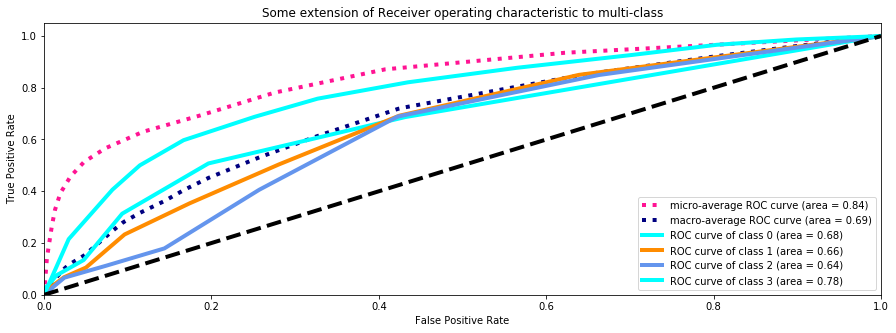

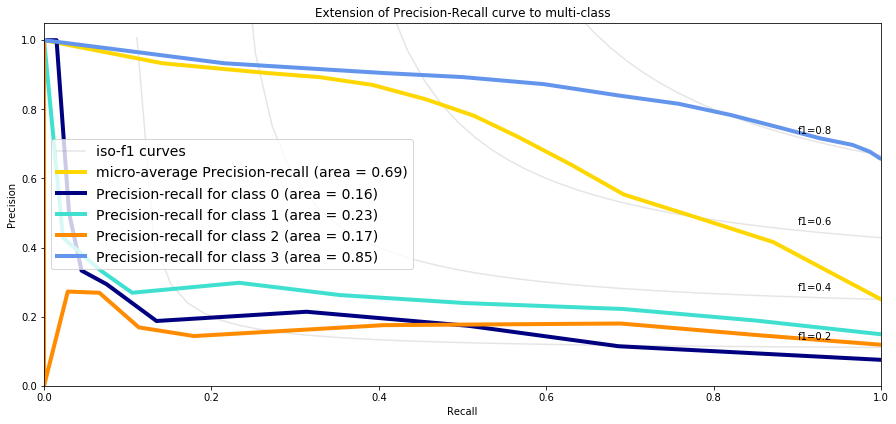

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.755262
Prediction  1   2   3    4  All
Actual                         
1           0   1   0    6    7
2           1   4   1   22   28
3           1   2   2   18   23
4           7  31  20  155  213
All         9  38  23  201  271
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 6}
Grid Search Best score  0.586955459059852
Code block 'training' took(HH:MM:SS): 0:00:24.824590
Code block 'testing' took(HH:MM:SS): 0:00:01.013119
F1 score 0.5941448023868162
Classification report  
               precision    recall  f1-score   support

           1       0.21      0.13      0.17        67
           2       0.29      0.19      0.23       133
           3       0.21      0.09      0.13       106
           4       0.74      0.90      0.81       586

   micro avg       0.64      0.64      0.64       892
   macro avg       0.36      0.33      0.33       892
weighted avg       0.57      0.64      0.59       892



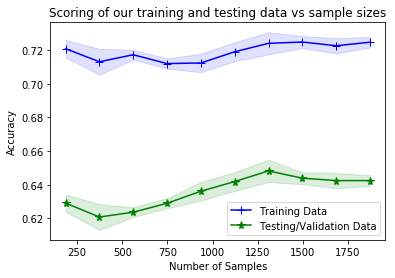

Confusion matrix, without normalization
[[  9  14   4  40]
 [ 16  25  16  76]
 [  5  17  10  74]
 [ 12  29  17 528]]


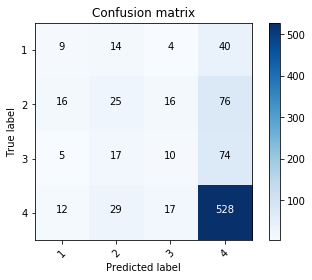

Code block 'learning_curve' took(HH:MM:SS): 0:01:16.919003
inside decision function


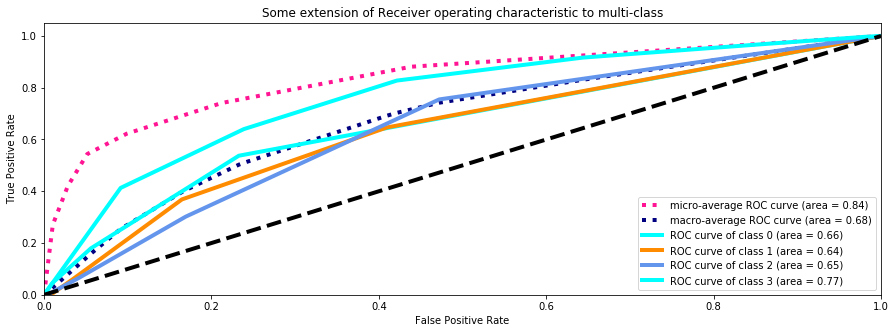

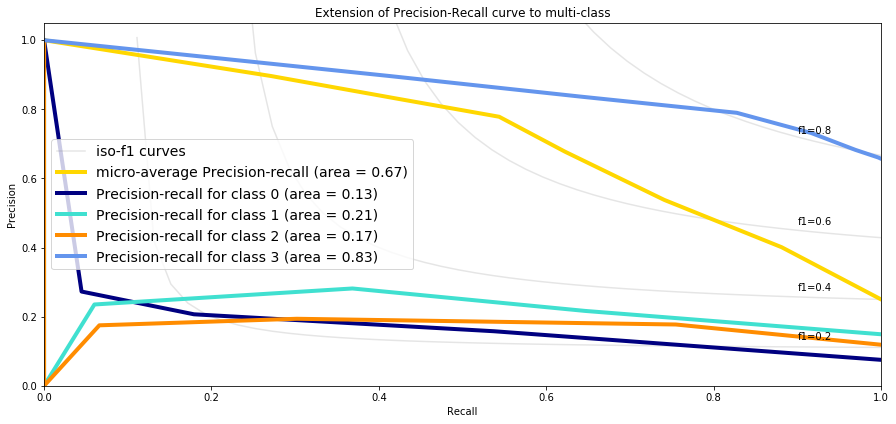

Code block 'predict_proba' took(HH:MM:SS): 0:00:01.585057
Prediction   1   2   3    4  All
Actual                          
1            1   2   1    3    7
2            1   4   0   23   28
3            1   5   2   15   23
4           11  17   9  176  213
All         14  28  12  217  271
Grid Search Best parameters  {'ridge__alpha': 1, 'ridge__max_iter': 100}
Grid Search Best score  0.6164810686753424
Code block 'training' took(HH:MM:SS): 0:00:02.297991
Code block 'testing' took(HH:MM:SS): 0:00:00.003781
F1 score 0.6069267887624569
Classification report  
               precision    recall  f1-score   support

           1       0.24      0.07      0.11        67
           2       0.37      0.28      0.32       133
           3       0.25      0.08      0.12       106
           4       0.73      0.92      0.82       586

   micro avg       0.66      0.66      0.66       892
   macro avg       0.40      0.34      0.34       892
weighted avg       0.58      0.66      0.61       892



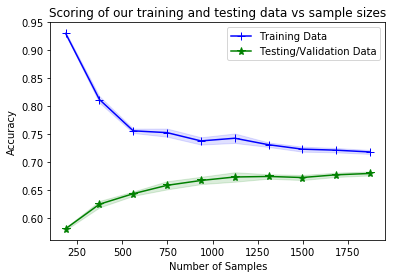

Confusion matrix, without normalization
[[  5  21   2  39]
 [  6  37   9  81]
 [  4  16   8  78]
 [  6  25  13 542]]


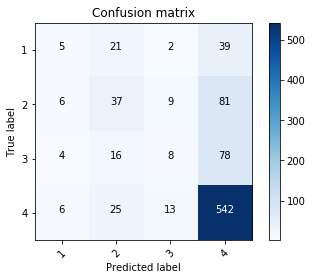

Code block 'learning_curve' took(HH:MM:SS): 0:00:03.667983
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000018
Prediction   1   2   3    4  All
Actual                          
1            0   1   0    6    7
2            1   4   1   22   28
3            1   2   1   19   23
4            8  20  11  174  213
All         10  27  13  221  271
Grid Search Best parameters  {'svc__C': 1.2, 'svc__max_iter': 200}
Grid Search Best score  0.07846953431888377
Code block 'training' took(HH:MM:SS): 0:01:43.975947
Code block 'testing' took(HH:MM:SS): 0:00:00.356497
F1 score 0.08178087308679406
Classification report  
               precision    recall  f1-score   support

           1       0.15      0.37      0.21        67
           2       0.27      0.29      0.28       133
           3       0.12      0.67      0.21       106
           4       0.00      0.00      0.00       586

   micro avg       0.15      0.15      0.15       892
   macro avg       0.13      0.33      0.17       892
we

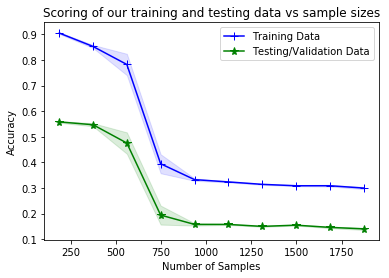

Confusion matrix, without normalization
[[ 25  13  29   0]
 [ 27  38  68   0]
 [ 17  18  71   0]
 [ 97  73 416   0]]


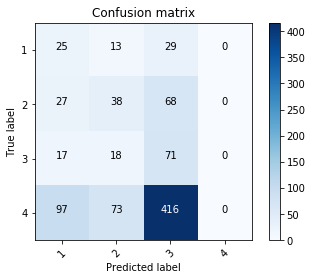

Code block 'learning_curve' took(HH:MM:SS): 0:03:57.379796
inside decision function


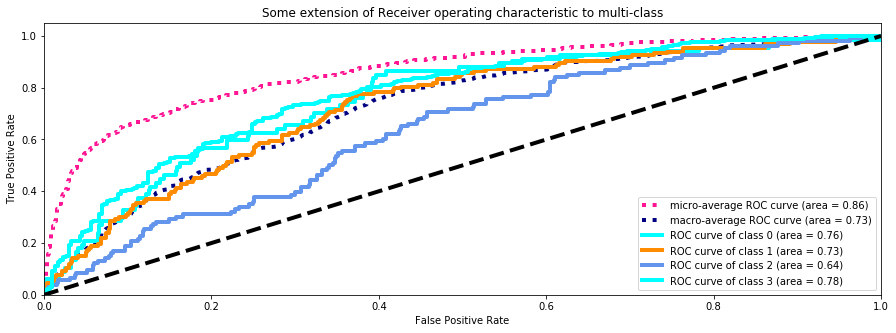

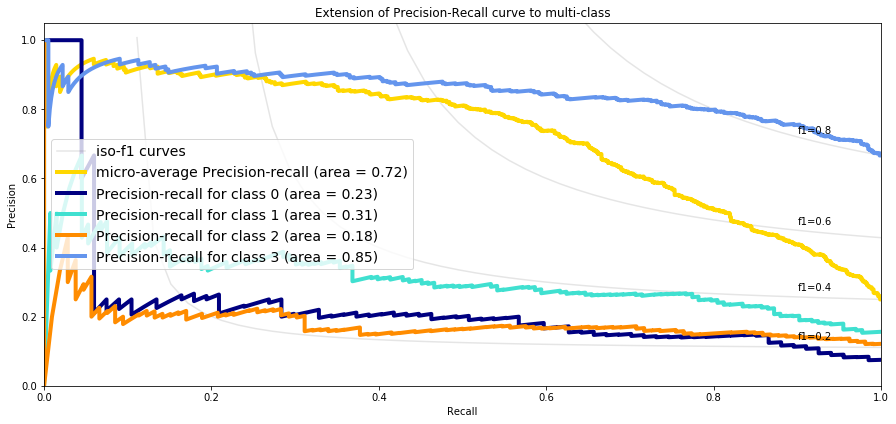

Code block 'predict_proba' took(HH:MM:SS): 0:00:01.044704
Prediction   1   2    3  All
Actual                      
1            1   0    6    7
2            3   8   17   28
3            4   7   12   23
4           44  26  143  213
All         52  41  178  271
Code block 'overalltime' took(HH:MM:SS): 0:11:59.689651
719689.650719388


In [33]:
response = execute(_x_train,
        _y_train,
        _x_test,
        _y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=scaler)

In [34]:
results = panda.DataFrame(response).transpose()

# we are sorting our results using f1_score_micro, since it gives the best indicator for sorting multi class imbalanced set
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_macro',
         'roc_auc_micro',
         'testing_time',
         'training_time']]\
.sort_values(by=['f1_score_micro',],ascending=False)

,f1_score,f1_score_macro,f1_score_micro,learning_curve_time,roc_auc_macro,roc_auc_micro,testing_time,training_time
ridge,0.606927,0.34151,0.663677,3667.98,0,0,3.7814,2297.99
logisticregression,0.617662,0.367844,0.658072,178315,0.740316,0.859373,6.95125,59838.4
decisiontreeclassifier,0.594868,0.327709,0.642377,4989.86,0.718578,0.830042,6.21568,2779.75
kneighborsclassifier,0.594145,0.333758,0.641256,76919,0.677878,0.835289,1013.12,24824.6
randomforestclassifier,0.595314,0.343876,0.628924,7993.49,0.689347,0.837695,8.89571,1573.89
perceptron,0.593026,0.33935,0.608744,6067.84,0,0,18.6078,2145.34
svc,0.0817809,0.174188,0.150224,237380,0.726144,0.860979,356.497,103976


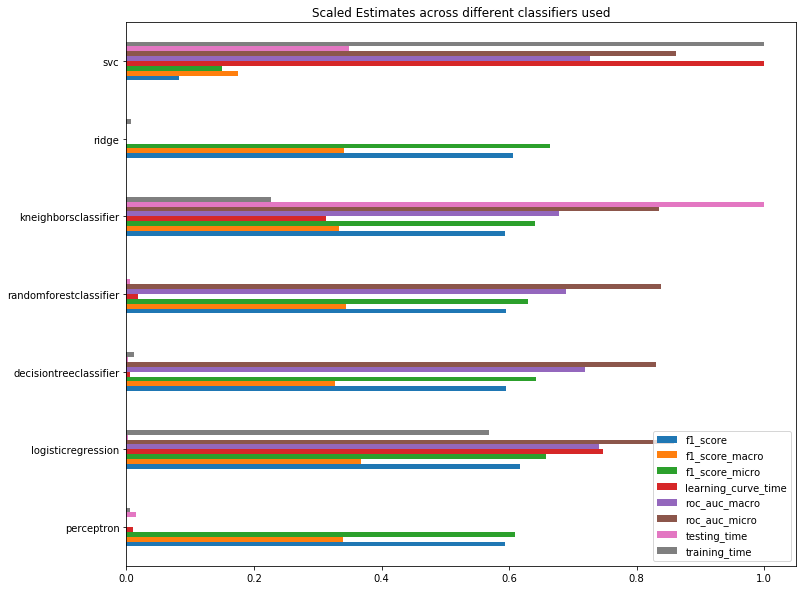

In [35]:
results['learning_curve_time'] = results['learning_curve_time'].astype('float64')
results['testing_time'] = results['testing_time'].astype('float64')
results['training_time'] = results['training_time'].astype('float64')
results['f1_score'] = results['f1_score'].astype('float64')
results['f1_score_micro'] = results['f1_score_micro'].astype('float64')
results['f1_score_macro'] = results['f1_score_macro'].astype('float64')
results['roc_auc_micro'] = results['roc_auc_micro'].astype('float64')
results['roc_auc_macro'] = results['roc_auc_macro'].astype('float64')

#scaling time parameters between 0 and 1
results['learning_curve_time'] = (results['learning_curve_time']- results['learning_curve_time'].min())/(results['learning_curve_time'].max()- results['learning_curve_time'].min())
results['testing_time'] = (results['testing_time']- results['testing_time'].min())/(results['testing_time'].max()- results['testing_time'].min())
results['training_time'] = (results['training_time']- results['training_time'].min())/(results['training_time'].max()- results['training_time'].min())

results.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

#### Conclusion on our separate cv and score parameter: Logistic Regression works the best with f1_micro score of 0.66 and roc score of 0.86



<br><br><br>
##### We will attempt ensembling techniques such as AdaBoostClassifier on models that worked well above

In [36]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats= 5, random_state =123)
score= 'f1_macro'
scaler = StandardScaler()

In [44]:

## we will add more classifiers in round2
classifiers = [
    AdaBoostClassifier(base_estimator=LogisticRegression(random_state = 1)),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
    AdaBoostClassifier(base_estimator=RandomForestClassifier(random_state = 1)),
    AdaBoostClassifier(base_estimator=KNeighborsClassifier(metric = 'minkowski')),
    AdaBoostClassifier(base_estimator = RidgeClassifier(random_state = 123)),
     
]


classifier_names = [
            'logisticregression',
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
            'ridge',
            'svc'
]

classifier_param_grid = [
            
 {'logisticregression__base_estimator__C':[100,300, 500],'logisticregression__n_estimators':[100,150,200],'logisticregression__learning_rate':[0.1,0.2,0.5]},
            {'decisiontreeclassifier__base_estimator__max_depth':[6,8,10],'decisiontreeclassifier__estimator__criterion':['gini','entropy'],'decisiontreeclassifier__n_estimators':[100,150,200],'decisiontreeclassifier__learning_rate':[0.1,0.2,0.5]},
            {'randomforestclassifier__base_estimator__n_estimators':[6,8,12],'randomforestclassifier__base_estimator__criterion': ['gini',],'randomforestclassifier__n_estimators':[100,150,200],'randomforestclassifier__learning_rate':[0.1,0.2,0.5]} ,
            {'kneighborsclassifier__base_estimator__n_neighbors':[4,6,10],'kneighborsclassifier__n_estimators':[100,150,200],'kneighborsclassifier__learning_rate':[0.1,0.2,0.5]},
            {'ridge__base_estimator__alpha':[1,1.2,0.9],'ridge__base_estimator__max_iter':[100,300,500],'ridge__n_estimators':[100,150,200],'ridge__learning_rate':[0.1,0.2,0.5]},
               
]


In [ ]:
response = execute(_x_train,
        _y_train,
        _x_test,
        _y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=scaler)

In [39]:
results = panda.DataFrame(response).transpose()

# we are sorting our results using f1_score_micro, since it gives the best indicator for sorting multi class imbalanced set
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_macro',
         'roc_auc_micro',
         'testing_time',
         'training_time']]\
.sort_values(by=['f1_score_micro',],ascending=False)

,f1_score,f1_score_macro,f1_score_micro,learning_curve_time,roc_auc_macro,roc_auc_micro,testing_time,training_time
ridge,0.605133,0.339595,0.662556,3539.42,0,0,5.2918,11331.2
logisticregression,0.617438,0.368012,0.658072,147616,0.741547,0.859759,4.89131,224585
kneighborsclassifier,0.594145,0.333758,0.641256,77390.2,0.677878,0.835289,1015.12,125786
randomforestclassifier,0.595314,0.343876,0.628924,8133.2,0.689347,0.837695,11.3209,7437.48
decisiontreeclassifier,0.602795,0.348685,0.618834,5694.85,0.654858,0.784126,6.20032,13780.9
perceptron,0.593026,0.33935,0.608744,4599.12,0,0,6.77888,7563.91
svc,0.0657776,0.150661,0.13565,231739,0.706819,0.854579,365.071,500846


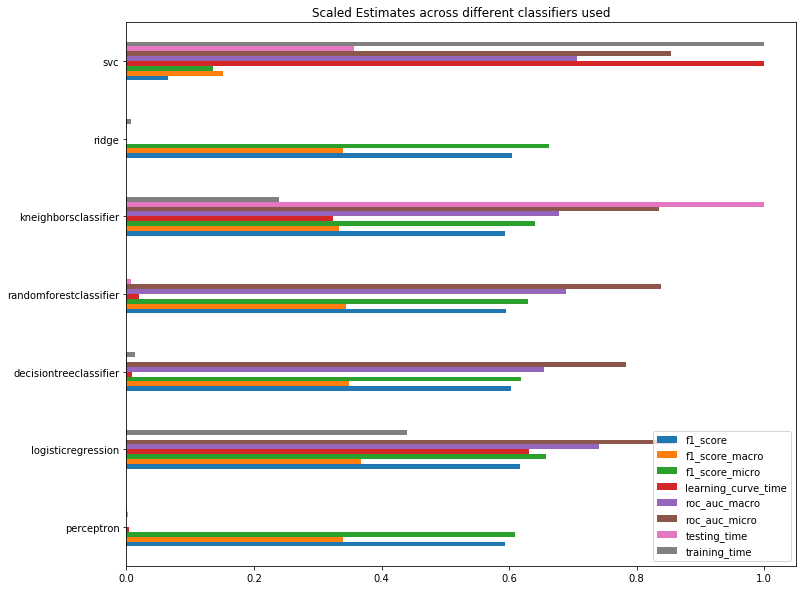

In [40]:
results['learning_curve_time'] = results['learning_curve_time'].astype('float64')
results['testing_time'] = results['testing_time'].astype('float64')
results['training_time'] = results['training_time'].astype('float64')
results['f1_score'] = results['f1_score'].astype('float64')
results['f1_score_micro'] = results['f1_score_micro'].astype('float64')
results['f1_score_macro'] = results['f1_score_macro'].astype('float64')
results['roc_auc_micro'] = results['roc_auc_micro'].astype('float64')
results['roc_auc_macro'] = results['roc_auc_macro'].astype('float64')

#scaling time parameters between 0 and 1
results['learning_curve_time'] = (results['learning_curve_time']- results['learning_curve_time'].min())/(results['learning_curve_time'].max()- results['learning_curve_time'].min())
results['testing_time'] = (results['testing_time']- results['testing_time'].min())/(results['testing_time'].max()- results['testing_time'].min())
results['training_time'] = (results['training_time']- results['training_time'].min())/(results['training_time'].max()- results['training_time'].min())

results.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

#### Conclusion on adaboosting: No improvement
